## Neutron Scattered Spectra Tool (NeSST) ##

This notebook will offer a quick guide to some of the functionality of NeSST

Standard packages:

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import sys
from pathlib import Path
NeSST_src = str(Path.cwd().parent.joinpath('src'))
sys.path.extend([NeSST_src])
import NeSST as nst

NeSST is equipped to handle the primary and scattered components found in DT plasmas

In [2]:
# Atomic fraction of D and T in scattering medium and source
nst.frac_D_default = 0.5
nst.frac_T_default = 0.5

### Primary Neutron Spectra ###

DT and DD primary neutron spectra can be constructed for Ballabio's spectral moments and appropriate spectrum form. Reactivities are taken from Bosch & Hale (or in the case of TT from direct integration of ENDF data).

In [3]:
Tion = 5.0 # keV
Y_DT = 1.0 # DT neutron yield, all reactions scaled by this value

DTmean,DTvar = nst.DTprimspecmoments(Tion)
DDmean,DDvar = nst.DDprimspecmoments(Tion)

Y_DD = nst.yield_from_dt_yield_ratio('dd',Y_DT,Tion)
Y_TT = nst.yield_from_dt_yield_ratio('tt',Y_DT,Tion)

# DD and TT grid
E_pspec = np.linspace(1.0,10.0,300)
# DT grid
E_DTspec = np.linspace(12.5,15.5,200)
E_pspec = np.append(E_pspec,E_DTspec)

dNdE_DT = Y_DT*nst.Qb(E_pspec,DTmean,DTvar) # Brysk shape i.e. Gaussian
dNdE_DD = Y_DD*nst.Qb(E_pspec,DDmean,DDvar) # Brysk shape i.e. Gaussian
dNdE_TT = Y_TT*nst.dNdE_TT(E_pspec,Tion)

Text(0, 0.5, 'dN/dE (1/MeV)')

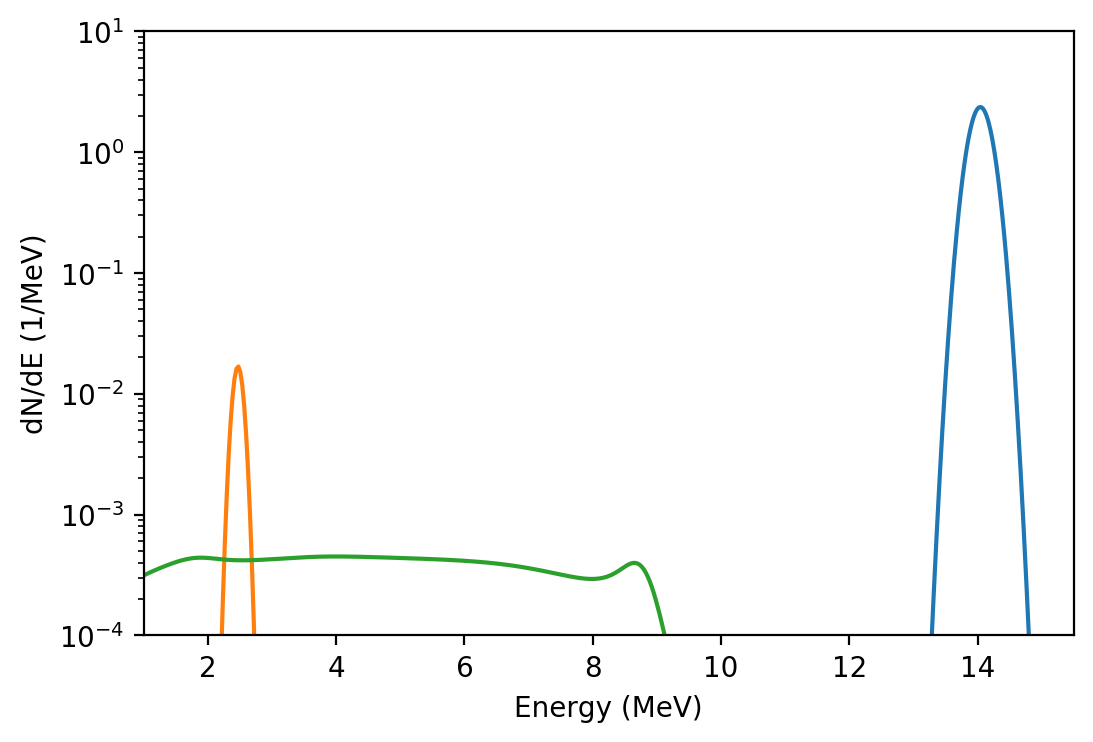

In [4]:
plt.figure(dpi=200)

plt.semilogy(E_pspec,dNdE_DT)
plt.semilogy(E_pspec,dNdE_DD)
plt.semilogy(E_pspec,dNdE_TT)

plt.xlim(E_pspec[0],E_pspec[-1])
plt.ylim(1e-4,1e1)
plt.xlabel("Energy (MeV)")
plt.ylabel("dN/dE (1/MeV)")

### Cross sections ###

For the elastic nT and nD scattering we use ENDF total and differential cross sections. These are defined using a Legendre polynomial expansions.

For the D(n,2n) process, we use the CENDL double differential cross section - the $d\sigma/dE$ of this data has been compared against the Deltuva calculation and shows good agreement

For the T(n,2n) process, we use the ENDF cross section and LAW=6 phase space law - this process carries the most uncertainity in terms of spectral shape and magnitude

### Scattered spectra for symmetric areal density ###

Scattered spectra for symmetric areal density are calculated from the single differential cross sections:

$$\frac{dN}{dE}_{\mathrm{scatter}} = A_{1S}\int dE' \frac{d\sigma}{dE}\frac{dN}{dE}_{\mathrm{primary}}, $$

where $A_{1S}$ is the single scatter amplitude which is directly proportional to the neutron-averaged areal density

In [5]:
I_prim = dNdE_DT+dNdE_DD+dNdE_TT

# Scattered spectra and primary spectra can be on separate grids
E_sspec = np.linspace(1.0,16.0,400)

# Neutron-averaged areal density in mg/cm2
rhoL = 150.0
# Need convert this into single scattering amplitude A_1S
A_1s = nst.rhoR_2_A1s(rhoL)

In [6]:
# Calculate d2sig/dEdmu on the given energy grids
nst.init_DT_scatter(E_sspec,E_pspec)

In [7]:
# Calculate the various scattering components for uniform areal density
dNdE_scatter,components = nst.sym_scatter_spec(I_prim)

By factoring out the areal density and yield scaling, this allows rapid evaluation of spectral shapes for different yields and areal densities

In [8]:
# Appropriate scaling by areal density
dNdE_scatter *= A_1s
nD,nT,Dn2n,Tn2n = components
nD *= A_1s
nT *= A_1s
Dn2n *= A_1s
Tn2n *= A_1s

Text(0, 0.5, 'dN/dE (1/MeV)')

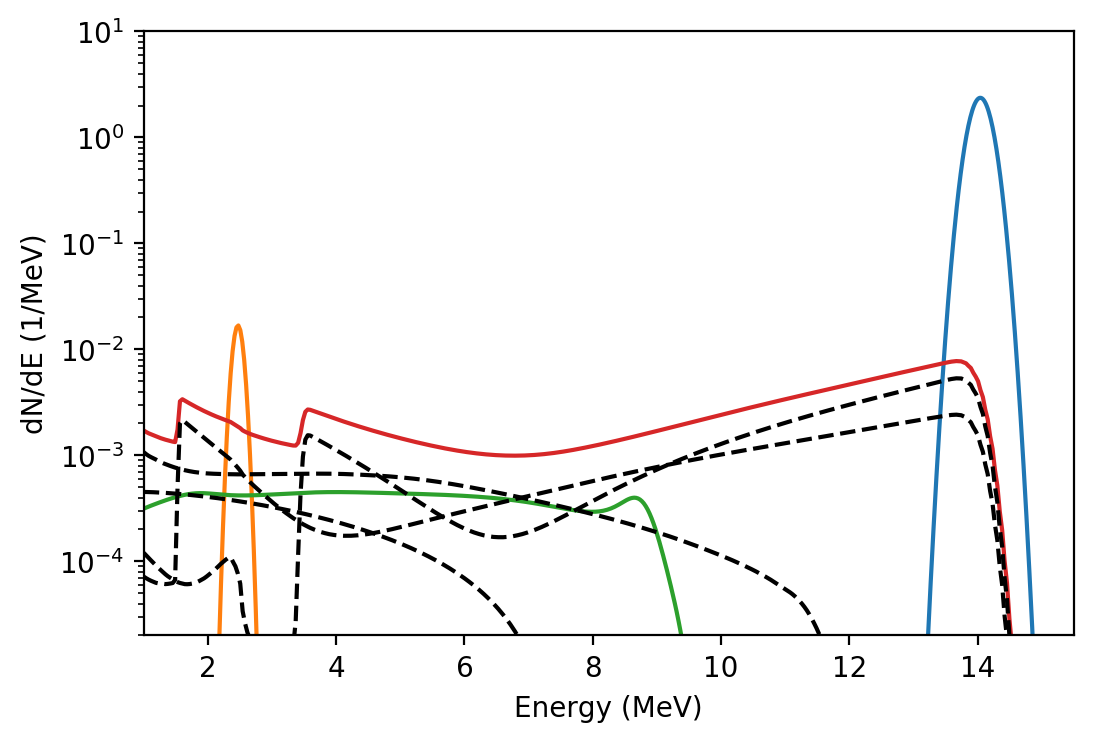

In [9]:
plt.figure(dpi=200)

plt.semilogy(E_pspec,dNdE_DT)
plt.semilogy(E_pspec,dNdE_DD)
plt.semilogy(E_pspec,dNdE_TT)
plt.semilogy(E_sspec,dNdE_scatter)
#Components
plt.semilogy(E_sspec,nD,'k--')
plt.semilogy(E_sspec,nT,'k--')
plt.semilogy(E_sspec,Dn2n,'k--')
plt.semilogy(E_sspec,Tn2n,'k--')

plt.xlim(E_pspec[0],E_pspec[-1])
plt.ylim(2e-5,1e1)
plt.xlabel("Energy (MeV)")
plt.ylabel("dN/dE (1/MeV)")

### Comparison to neutron transport solution ###

Minotaur is a 1D spherical discrete ordinates neutron transport code which computes neutron spectra based on input hydrodynamic profiles for ICF implosions. Transport effects, temperature and density profiles, and multiple scattering absent from NeSST can be quantified by Minotaur. For details on the code see "Synthetic nuclear diagnostics for inferring plasma properties of inertial confinement fusion implosions" https://aip.scitation.org/doi/full/10.1063/1.5027462

Here we compare NeSST's scattered spectrum to one calculated by Minotaur for an isobaric hotspot + cold shell model. This comparison will be performed at a rhoR of 200 mg/cm$^2$ - although the neutron-averaged areal density will not be exactly equal due to profile effects.

In [10]:
# Prepare NeSST result with Minotaur results
burn_avg_tion = 4.06487 # keV
Mino_Y_DT     = 9593467571589.95 # DT neutron yield

Mino_DTmean,Mino_DTvar = nst.DTprimspecmoments(burn_avg_tion)
Mino_DDmean,Mino_DDvar = nst.DDprimspecmoments(burn_avg_tion)

Mino_Y_DD = nst.yield_from_dt_yield_ratio('dd',Mino_Y_DT,burn_avg_tion)
Mino_Y_TT = nst.yield_from_dt_yield_ratio('tt',Mino_Y_DT,burn_avg_tion)

Mino_dNdE_DT = Mino_Y_DT*nst.Qb(E_sspec,Mino_DTmean,Mino_DTvar) # Brysk shape i.e. Gaussian
Mino_dNdE_DD = Mino_Y_DD*nst.Qb(E_sspec,Mino_DDmean,Mino_DDvar) # Brysk shape i.e. Gaussian
Mino_dNdE_TT = Mino_Y_TT*nst.dNdE_TT(E_sspec,burn_avg_tion)

Mino_I_prim = Mino_dNdE_DT+Mino_dNdE_DD+Mino_dNdE_TT

# Calculate d2sig/dEdmu on the given energy grids
nst.init_DT_scatter(E_sspec,E_sspec)

Mino_dNdE_scatter,Mino_components = nst.sym_scatter_spec(Mino_I_prim)

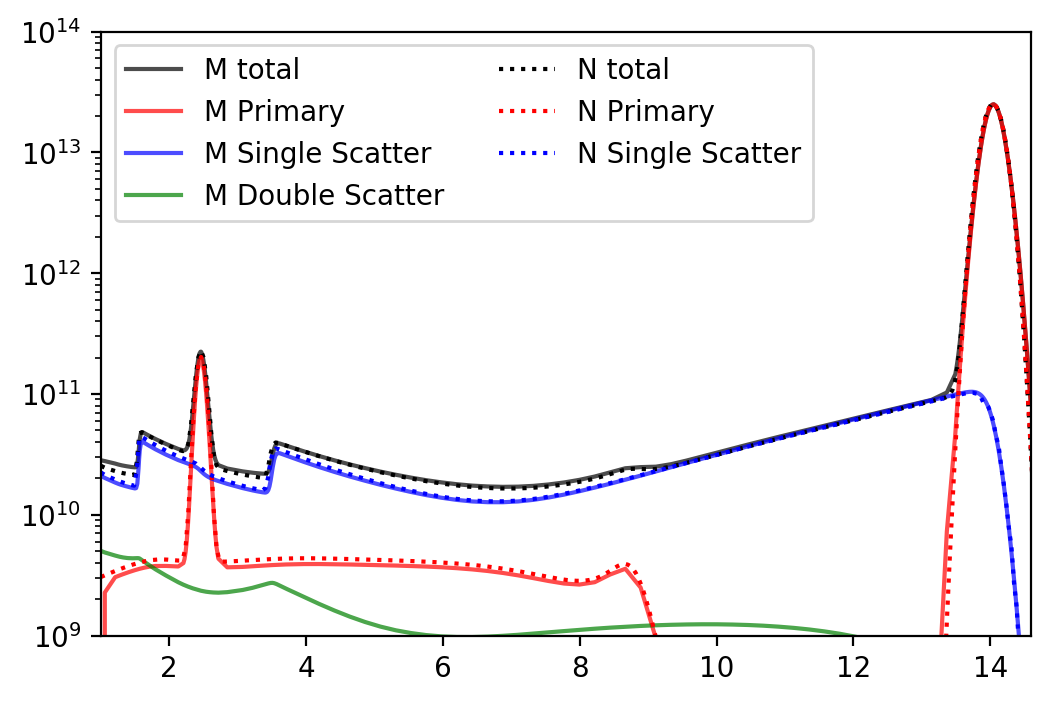

In [11]:
Minotaur_data = np.loadtxt("energy_spec_200mgcm2_isobaric_NeSST.dat")

plt.figure(dpi=200)

plt.semilogy(Minotaur_data[:,0],Minotaur_data[:,3],'k',alpha=0.7,label='M total')
plt.semilogy(Minotaur_data[:,0],Minotaur_data[:,5],'r',alpha=0.7,label='M Primary')
plt.semilogy(Minotaur_data[:,0],Minotaur_data[:,6],'b',alpha=0.7,label='M Single Scatter')
plt.semilogy(Minotaur_data[:,0],Minotaur_data[:,7],'g',alpha=0.7,label='M Double Scatter')

Mino_A_1s = nst.rhoR_2_A1s(203.0)

plt.semilogy(E_sspec,Mino_I_prim+Mino_A_1s*Mino_dNdE_scatter,'k:',label='N total')
plt.semilogy(E_sspec,Mino_I_prim,'r:',label='N Primary')
plt.semilogy(E_sspec,Mino_A_1s*Mino_dNdE_scatter,'b:',label='N Single Scatter')

plt.legend(ncol=2)
plt.xlim(1.0,Minotaur_data[0,0])
plt.ylim(1e9,1e14);

Minotaur results are labelled 'M' and NeSST results are labelled 'N'

The comparison shows the strength and speed of NeSST in the single scatter regime, where the double scattering contribution can be considered a small background.

Also note the differences in the backscatter edge positions - this is due to the relativistic corrections present in NeSST but not Minotaur

### Scattered spectra for arbitrary areal density asymmetry ###

Scattered spectra for asymmetric areal density distributions are calculated from the double differential cross sections:

$$\frac{dN}{dE}_{\mathrm{scatter}} = A_{1S}\int d\mu \frac{\langle \rho L \rangle (\mu)}{\langle \rho L \rangle_0} \int dE' \frac{d^2\sigma}{dEd\mu}\frac{dN}{dE}_{\mathrm{primary}}, $$

where $\langle \rho L \rangle (\mu)$ is the project areal density asymmetry along the line of sight and $\langle \rho L \rangle_0$ is the mode 0 i.e. 4 $\pi$ average areal density.

For details on this treatment see "The effect of areal density asymmetries on scattered neutron spectra in ICF implosions" https://aip.scitation.org/doi/full/10.1063/5.0038752

In [12]:
# Swap back to separate primary and scattered spectra grids
# Calculate d2sig/dEdmu on the given energy grids
nst.init_DT_scatter(E_sspec,E_pspec)

Text(0, 0.5, 'Normalised Areal Density')

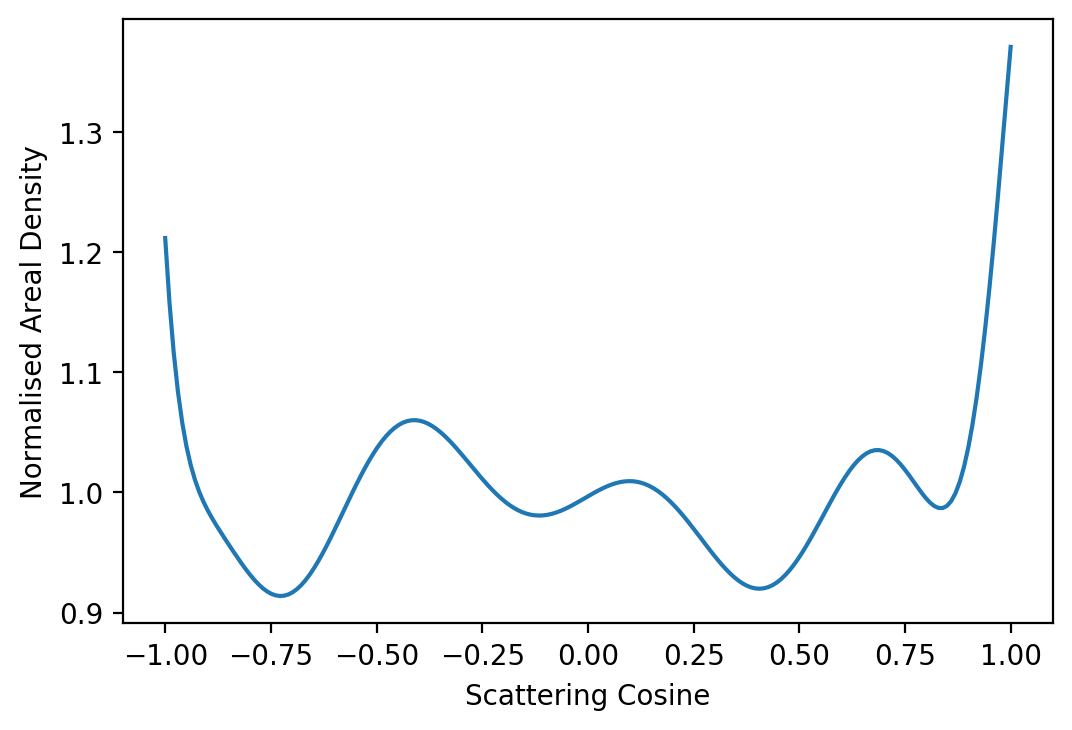

In [13]:
def rhoL_func(cos,p):
    return np.polynomial.legendre.legval(cos,p)

coeff = 0.2*(np.random.rand(12)-0.5)
coeff[0] = 1.0

fig = plt.figure(dpi=200)

cos = np.linspace(-1,1,200)

plt.plot(cos,rhoL_func(cos,coeff))
plt.xlabel("Scattering Cosine")
plt.ylabel("Normalised Areal Density")

In [14]:
# Use the defined areal density asymmetry function to find scattered spectrum
asym_dNdE_scatter, components = nst.asym_scatter_spec(I_prim,lambda x: rhoL_func(x,coeff))

In [15]:
# Appropriate scaling by areal density
asym_dNdE_scatter *= A_1s

Text(0, 0.5, 'dN/dE (1/MeV)')

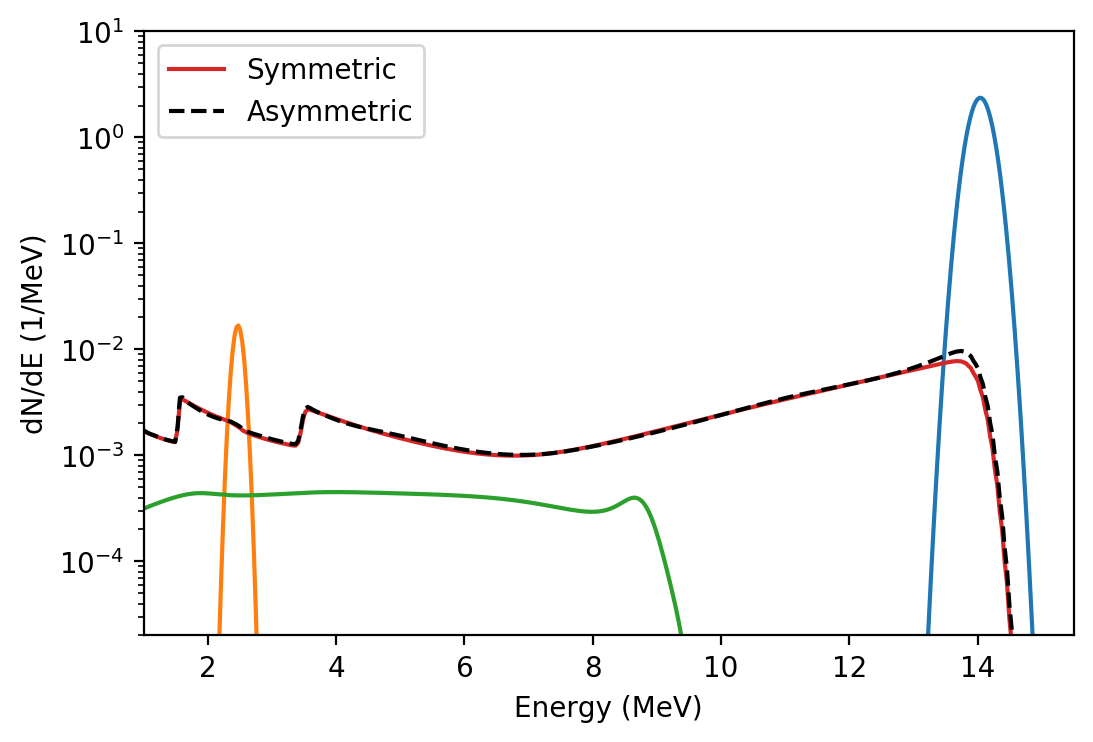

In [16]:
plt.figure(dpi=200)

plt.semilogy(E_pspec,dNdE_DT)
plt.semilogy(E_pspec,dNdE_DD)
plt.semilogy(E_pspec,dNdE_TT)
plt.semilogy(E_sspec,dNdE_scatter,label='Symmetric')
plt.semilogy(E_sspec,asym_dNdE_scatter,'k--',label='Asymmetric')

plt.legend()
plt.xlim(E_pspec[0],E_pspec[-1])
plt.ylim(2e-5,1e1)
plt.xlabel("Energy (MeV)")
plt.ylabel("dN/dE (1/MeV)")

### Scattered spectra for mode 1 areal density asymmetry ###

NeSST has special functions to handle the common mode 1 Legendre expansion of $\langle \rho L \rangle (\mu)$

Here will introduce the premade splining tools in NeSST

In [11]:
# Array of P1s to evaluate
P1_arr = np.linspace(-0.5,0.5,21)

nTspline,nDspline,Dn2nspline,Tn2nspline = nst.calc_all_splines(E_sspec,E_pspec,I_prim,P1_arr)

Text(0, 0.5, 'dN/dE (1/MeV)')

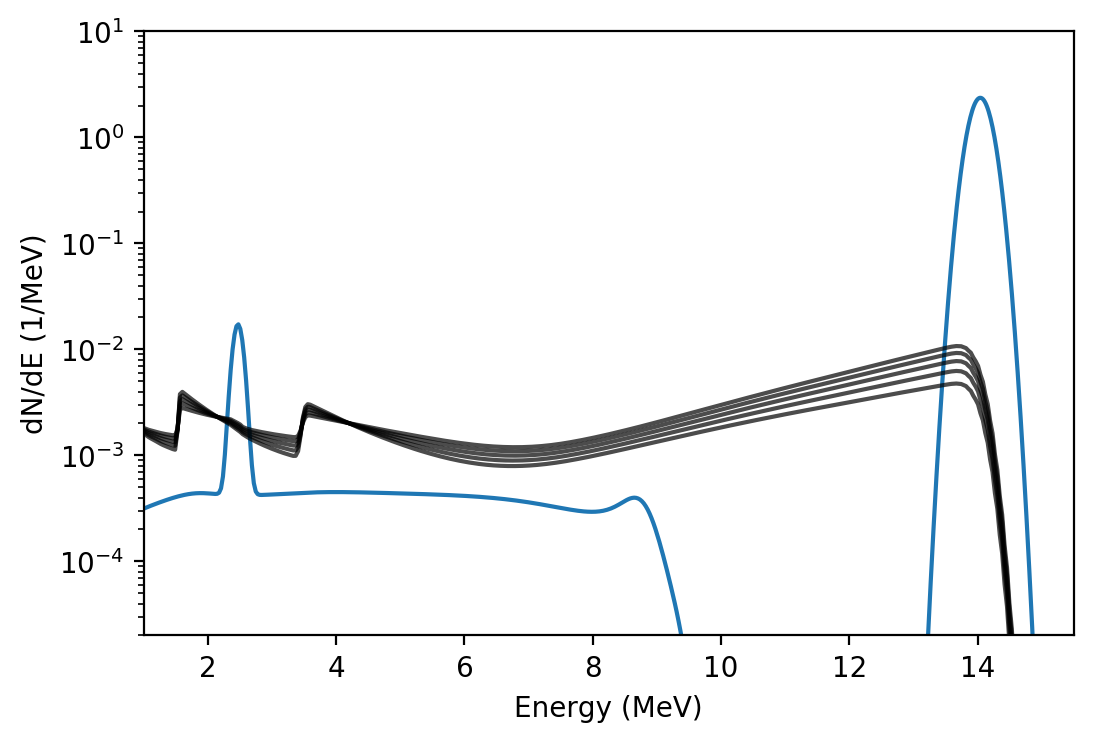

In [12]:
plt.figure(dpi=200)

P1_plot = [-0.4,-0.2,0.0,0.2,0.4]

plt.semilogy(E_pspec,I_prim)
for P1 in P1_plot:
    dNdE_scatter = A_1s*(nTspline(E_sspec,P1)+nDspline(E_sspec,P1)+Dn2nspline(E_sspec,P1)+Tn2nspline(E_sspec,P1))
    plt.semilogy(E_sspec,dNdE_scatter,'k',alpha=0.7)

plt.xlim(E_pspec[0],E_pspec[-1])
plt.ylim(2e-5,1e1)
plt.xlabel("Energy (MeV)")
plt.ylabel("dN/dE (1/MeV)")

### Effect of scattering ion kinematics on backscatter edge shape ###

The theory behind this effect is outlined in "Neutron backscatter edge: A measure of the hydrodynamic properties of the dense DT fuel at stagnation in ICF experiments" https://aip.scitation.org/doi/full/10.1063/1.5128830

First, we must construct a ion velocity dependent scattering kernel. We concentrate on the scattering of DT neutrons:

In [73]:
# Energy grid for nT edge, zoom in on region of interest
E_nT = np.linspace(3.0,4.5,200)
# DT spectrum on DT spec grid
I_DT = nst.Qb(E_DTspec,DTmean,DTvar)
# Ion velocity grid
varr = np.linspace(-800e3,800e3,100)
M = nst.matrix_calc(E_nT,varr,E_DTspec,I_DT,'nT')

In [75]:
nst.sm.mat_T.init_station_scatter_matrices(E_nT,E_DTspec)
nst.sm.mat_T.calc_station_elastic_dNdE(I_DT,lambda x : np.ones_like(x))

For Gaussian ion velocity distributions, there are inbuilt functions to convert this scattering kernel to a dNdE. For a more general PDF use nst.generate_velocity_weighted_spectrum_w_PDF

In [76]:
# Mean and std. dev. of ion velocity distribution
vbar = 80.0e3 # m/s
dv   = 250.0e3 # m/s

dNdE_nT = A_1s*nst.frac_T_default*nst.generate_velocity_weighted_spectrum(M,E_nT,vbar,dv,varr,E_nT)
dNdE_nT_noionvel = A_1s*nst.frac_T_default*nst.sm.mat_T.elastic_dNdE

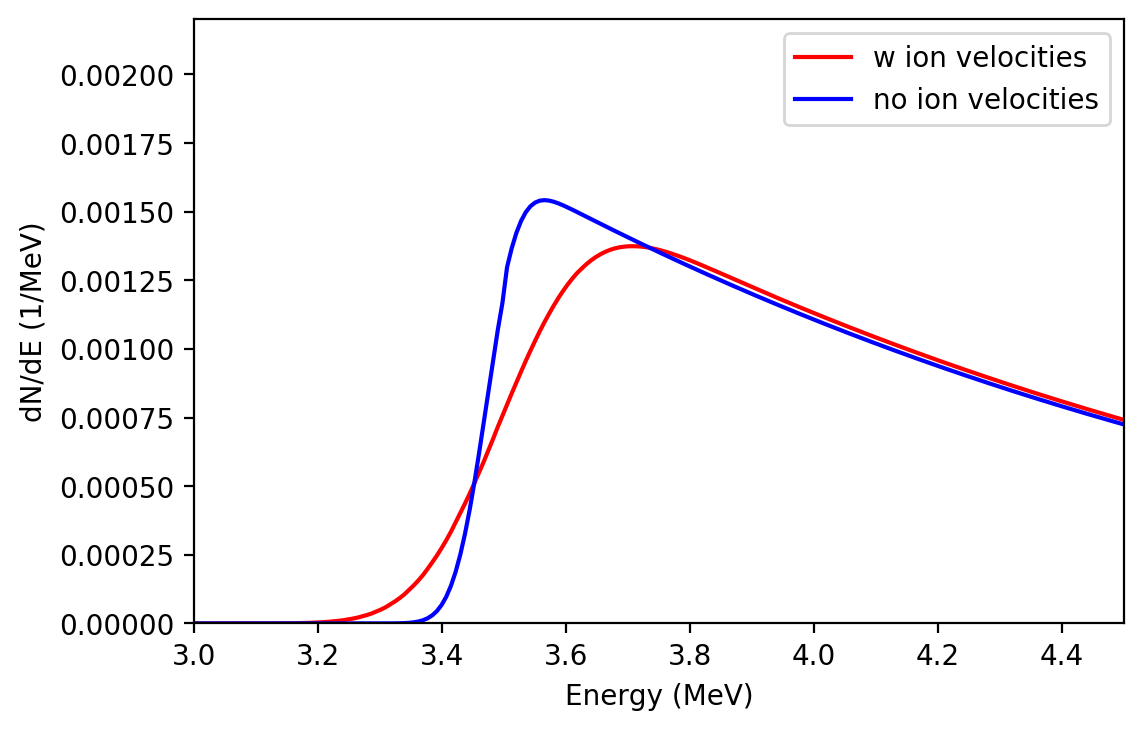

In [77]:
plt.figure(dpi=200)

plt.plot(E_nT,dNdE_nT,'r',label='w ion velocities')
plt.plot(E_nT,dNdE_nT_noionvel,'b',label='no ion velocities')

plt.xlim(E_nT[0],E_nT[-1])
plt.ylim(0,2.2e-3)
plt.xlabel("Energy (MeV)")
plt.ylabel("dN/dE (1/MeV)")
plt.legend()

### Additional scatter materials ###

NeSST can include the scattering from non-fuel components through the material_data object in the NeSST.spectral_model library. The currently available materials are stored in NeSST.spectral_model.available_materials.

In [17]:
print(nst.sm.available_materials)

['D', 'T', '9Be']


We will see how to use these additional material data objects using 9Be as an example

We need to supply the energy grids for the primary and scattered spectra, and the areal density as a function of scattering cosine. NeSST will then calculate the unscaled dNdEs.

In [20]:
nst.sm.mat_9Be.init_station_scatter_matrices(E_sspec,E_pspec)
nst.sm.mat_9Be.calc_dNdEs(dNdE_DD,lambda x : np.ones_like(x))

Each material has an in-built way to calculate the conversion between material areal density and scatter fraction (A_1S).

Text(0, 0.5, 'dN/dE (1/MeV)')

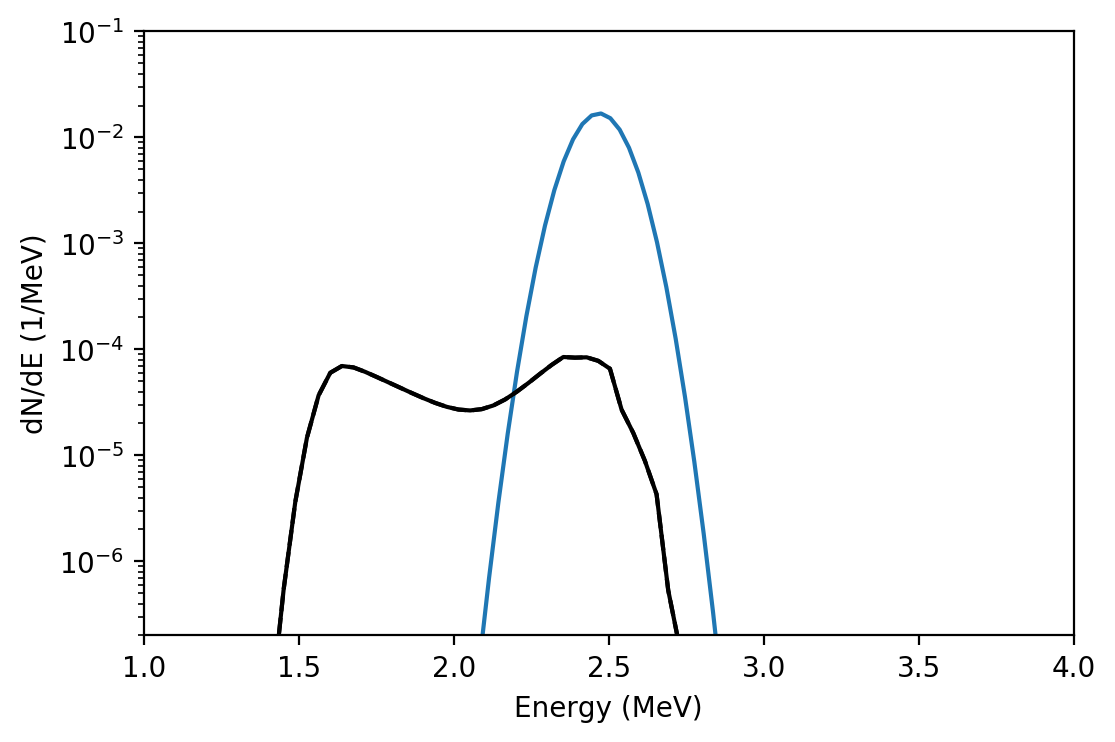

In [23]:
rhoR = 100 #mg/cm^2
A_1S = nst.sm.mat_9Be.rhoR_2_A1s(rhoR)

plt.figure(dpi=200)

plt.semilogy(E_pspec,dNdE_DD)
dNdE_scatter = A_1S*nst.sm.mat_9Be.elastic_dNdE+A_1S*nst.sm.mat_9Be.n2n_dNdE
plt.semilogy(E_sspec,dNdE_scatter,'k')
# Components
plt.semilogy(E_sspec,A_1S*nst.sm.mat_9Be.elastic_dNdE,'k--')
plt.semilogy(E_sspec,A_1S*nst.sm.mat_9Be.n2n_dNdE,'k:')

plt.xlim(E_pspec[0],4.0)
plt.ylim(2e-7,1e-1)
plt.xlabel("Energy (MeV)")
plt.ylabel("dN/dE (1/MeV)")